In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from src.evaluate_regression import get_rankings, average_spearman

sns.set_palette("Paired")

# Load Data

In [53]:
FACTORS = ["dataset", "model", "tuning", "scoring"]
NEW_INDEX = "encoder"

In [54]:
# Load Train Data
X_train = pd.read_csv("../../data/preprocessed/X_train.csv")
y_train = pd.read_csv("../../data/preprocessed/y_train.csv")

# Load holdout data
X_holdout_original = pd.read_csv("../../data/preprocessed/X_hold_out_original.csv")
X_holdout = pd.read_csv("../../data/preprocessed/X_holdout.csv")
y_holdout = pd.read_csv("../../data/preprocessed/y_holdout.csv")

print("Shape of X_train ", X_train.shape)
print("Shape of y_train ", y_train.shape)
print(50 * "-")
print("Shape of X_holdout_original ", X_holdout_original.shape)
print("Shape of X_holdout ", X_holdout.shape)
print("Shape of y_holdout ", y_holdout.shape)

X_train.head(5)

Shape of X_train  (26989, 112)
Shape of y_train  (26989, 1)
--------------------------------------------------
Shape of X_holdout_original  (9065, 5)
Shape of X_holdout  (9065, 112)
Shape of y_holdout  (9065, 1)


,dataset,model_DTC,model_KNC,model_LGBMC,model_LR,model_SVC,tuning_full,tuning_model,tuning_no,scoring_ACC,...,non_categorical_features_count,ratio_of_categorical_features_to_all,sum_of_all_categories,categorical_target_variables_count,non_categorical_target_variables_count,categorical_target_values_sum,total_feature_count,min_number_of_categories_per_cat_feature,max_number_of_categories_per_cat_feature,avg_number_of_categories_per_cat_feature
0,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
1,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
2,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
3,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681
4,0.025297,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.564327,0.045059,1.0,0.0,0.0,0.0,0.476695,0.0,0.705853,0.429681


# Prepare for ordinal regression

In [55]:
y_train.head(5)

,rank
0,21.0
1,19.0
2,26.0
3,12.0
4,28.0


In [56]:
def transform_y_train_to_multi_output_binary_classification(y_train: pd.DataFrame, verbosity:int =0) -> pd.DataFrame:
    """
    Transforms y_train to the schema that a multi output binary classification problem expects.
    Transform rank into 31 binary targets, y_i’s: y_i = 1 if rank > i, 0 otherwise
    Note that y_i = 1 implies y_{i-1} = 1.

    :param y_train: pd.DataFrame -- Dataframe of the labels of the train set
    :param verbosity: int -- Level of verbosity

    :return: y_train: pd.DataFrame -- Transformed dataframe
    """
    y_train = y_train.copy()

    if verbosity > 0:
        print("Transforming y_train to multi output binary classifcation ...")

    # y_i’s: y_i = 1 if rank > i, 0 otherwise
    for i in range(int(y_train["rank"].max())):
        y_train[f"y{i}"] = (y_train["rank"] > i).astype(int)
    # Drop original target
    y_train.drop("rank", axis=1, inplace=True)

    return y_train

y_train = transform_y_train_to_multi_output_binary_classification(y_train=y_train)
y_train.head(5)

,y0,y1,y2,y3,y4,y5,y6,y7,y8,y9,...,y21,y22,y23,y24,y25,y26,y27,y28,y29,y30
0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,0,0,0,0,0
3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,0,0,0


# Modelling

In [57]:
# Define models to test
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
extratree = ExtraTreeClassifier(random_state=42)
extratrees = ExtraTreesClassifier(random_state=42, n_jobs=-1)
knn = KNeighborsClassifier(n_jobs=-1)

models = [dt, rf, extratree, extratrees, knn]

def fit_and_predict(models: list, X_train: pd.DataFrame, y_train: pd.DataFrame, X_holdout):
    """
    Function to fit and predict multiple models.

    :param models: list -- List of initialized models
    :param X_train: pd.DataFrame -- Dataframe containing the train values
    :param y_train: pd.DataFrame -- Dataframe containing the labels of the train values, must be transformed first!
    :param X_holdout: pd.DataFrame -- Dataframe containing the holdout set values

    :return: models_and_prediction: dict -- Dict of model strings and y_preds as well as fitted_models: list of fitted model objects
    """
    models_and_prediction: dict = {}
    fitted_models: list = []

    for model in models:
        model_string = str(model).split("(")[0]
        print(f"Fitting model {model_string} ...")
        # Fit each model
        model.fit(X_train, y_train)
        fitted_models.append(model)

        print(f"Predicting ... \n")
        # Predicting
        y_pred = model.predict(X_holdout)

        # Append results
        models_and_prediction[model_string] = y_pred

    return models_and_prediction, fitted_models


In [58]:
models_and_prediction, fitted_models = fit_and_predict(models, X_train, y_train, X_holdout)

Fitting model DecisionTreeClassifier ...
Predicting ... 

Fitting model RandomForestClassifier ...
Predicting ... 

Fitting model ExtraTreeClassifier ...
Predicting ... 

Fitting model ExtraTreesClassifier ...
Predicting ... 

Fitting model KNeighborsClassifier ...
Predicting ... 



# Scoring

In [59]:
def score_model(X_holdout_original: pd.DataFrame, y_holdout, y_pred, verbosity = 1):
    """
    Scores the prediction set y_pred using the provided functions from supervisor.

    :param X_holdout_original: pd.DataFrame -- Schema of the original holdout set before any processing
    :param y_holdout: pd.DataFrame -- Dataframe of the labels of the holdout set
    :param y_pred: Vector -- Vector of the predicted labels of the holdout set X_holdout
    :param verbosity: int -- Level of verbosity

    :return: average_spearman_sum, average_spearman_min
    """
    X_holdout_original["rank"] = y_holdout
    X_holdout_original["rank_pred_sum"] = y_pred.sum(axis=1)
    X_holdout_original["rank_pred_min"] = np.argmin(y_pred, axis=1) - 1

    rankings_test = get_rankings(X_holdout_original, factors=FACTORS, new_index=NEW_INDEX, target="rank")
    rankings_pred_sum = get_rankings(X_holdout_original, factors=FACTORS, new_index=NEW_INDEX, target="rank_pred_sum")
    rankings_pred_min = get_rankings(X_holdout_original, factors=FACTORS, new_index=NEW_INDEX, target="rank_pred_min")

    average_spearman_sum = average_spearman(rankings_test, rankings_pred_sum)
    average_spearman_min = average_spearman(rankings_test, rankings_pred_min)

    if verbosity > 0:
        print("Ordinal regression average spearman:\n",
            f"Sum: {average_spearman_sum:.4f}\n",
            f"Min: {average_spearman_min:.4f}")

    return average_spearman_sum, average_spearman_min


# Scoring multiple models at once

In [60]:
def score_multiple_models(models_and_prediction: dict, verbosity:int = 0) -> pd.DataFrame:
    """
    Function to score multiple models at once and get result dataframe

    :param models_and_prediction: dict -- Dictionary containing the model string as key and y_pred as values
    :param verbosity: int -- Level of verbosity

    :return: results_df: pd.DataFrame -- Dataframe containing the spearman scores and the model string
    """

    # Empty lists to populate
    models_str = []
    avg_spearman_sum_list = []
    avg_spearman_min_list = []

    # Iterate through each models prediction y_pred
    for model_str, y_pred in models_and_prediction.items():

        if verbosity > 0:
            print(f"Scoring for {model_str}:")
        average_spearman_sum, average_spearman_min = score_model(X_holdout_original, y_holdout, y_pred=y_pred, verbosity=verbosity)
        if verbosity > 0:
            print()

        # For populating df
        models_str.append(model_str)
        avg_spearman_sum_list.append(average_spearman_sum)
        avg_spearman_min_list.append(average_spearman_min)

    # Build result dataframe
    results_df = pd.DataFrame({
        "model": models_str,
        "average_spearman_sum": avg_spearman_sum_list,
        "average_spearman_min": avg_spearman_min_list
    })

    return results_df

results_df = score_multiple_models(models_and_prediction, verbosity=0)
results_df

,model,average_spearman_sum,average_spearman_min
0,DecisionTreeClassifier,0.635045,0.617004
1,RandomForestClassifier,0.694489,0.687978
2,ExtraTreeClassifier,0.551831,0.540810
3,ExtraTreesClassifier,0.717459,0.708420
4,KNeighborsClassifier,0.205728,0.205080


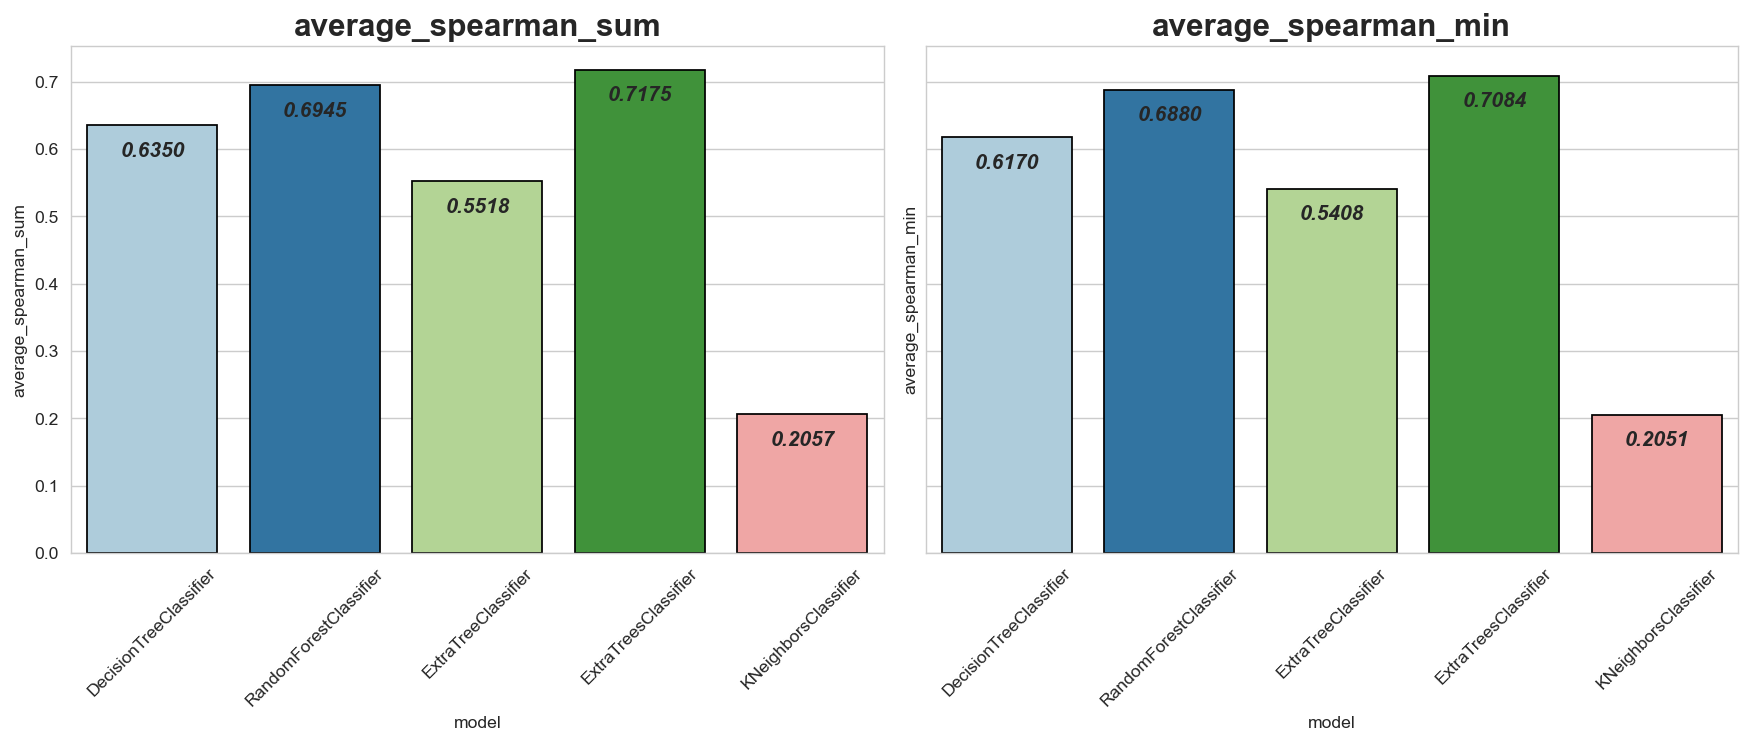

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), dpi=126, sharey=True)
for ax, col in zip(axes.flatten(), [col for col in results_df.columns if col != "model"]):
    ax.set_title(col, size=18, fontweight="bold")
    g = sns.barplot(data=results_df, x="model", y=col, ax=ax, edgecolor="black")
    ax.bar_label(ax.containers[0], fmt="%.4f", size=12, fontweight="bold", style="italic", padding=-20)
    ax.tick_params(axis='x', labelrotation=45)
plt.tight_layout()
plt.show()